# Analyze Consumer With External Dataset
- Analyze Consumer count for each state and sa2 region
- Analyze the top 100 sa2 regions with the most consumers and see which states they come from
- Analyze the comparison between the official sex ratio of each state and the sex ratio of customers
- Analyze the distribution of sex ratio in the top 100 sa2 regions with the largest number of customer sources

In [2]:
import sys  
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pyspark.sql import DataFrame
curr_path = str(Path(os.getcwd()).parent)
sys.path.append(curr_path)
from scripts.constants import *
from scripts.plotting import *
from scripts.read import *
from scripts.join import *

In [4]:
spark = create_spark()

### Read the required dataframes

In [5]:
# read the external data
external_data = read_curated_external_joined_data(prefix=".")
consumer_data = read_curated_tbl_consumer(spark, prefix=".")

- We want to analyze the consumer count for each state and sa2 region first

In [6]:
# select postcode, sa2 and ratio information from external data
postcode_and_sa2 = external_data[[POSTCODE, SA2_CODE, RATIO, SA2_NAME]]
# rename the column for joining
consumer_data = consumer_data.rename(columns={STATE: STE_NAME})

- Join the external data and the consumer data on the state name

In [7]:
joined_consumer_with_sa2 = join_consumer_and_external_data(consumer_data, postcode_and_sa2)
joined_consumer_with_sa2.head(10)

,name,address,state_name,postcode,gender,consumer_id,sa2_code,ratio,sa2_name
0,John Garza,90413 Wyatt Fort Apt. 516,SA,5301,Male,531402,407031169,0.575473,The Coorong
1,John Garza,90413 Wyatt Fort Apt. 516,SA,5301,Male,531402,407031161,0.424527,Karoonda - Lameroo
2,Latasha Rice,07972 Savannah Forest,SA,5301,Female,256822,407031169,0.575473,The Coorong
3,Latasha Rice,07972 Savannah Forest,SA,5301,Female,256822,407031161,0.424527,Karoonda - Lameroo
4,Andrew Steele,0149 Laura Bypass Apt. 350,SA,5301,Male,440042,407031169,0.575473,The Coorong
5,Andrew Steele,0149 Laura Bypass Apt. 350,SA,5301,Male,440042,407031161,0.424527,Karoonda - Lameroo
6,Lauren Hicks,63884 Valerie Pass Suite 287,SA,5301,Undisclosed,1092773,407031169,0.575473,The Coorong
7,Lauren Hicks,63884 Valerie Pass Suite 287,SA,5301,Undisclosed,1092773,407031161,0.424527,Karoonda - Lameroo
8,Michael Curtis,29523 Taylor Groves,SA,5301,Male,160739,407031169,0.575473,The Coorong
9,Michael Curtis,29523 Taylor Groves,SA,5301,Male,160739,407031161,0.424527,Karoonda - Lameroo


- Group by the state name, calculate the consumer count for each state

In [8]:
# group by the sa2 name and count the number of consumers
consumer_count_per_state = joined_consumer_with_sa2.groupby(STE_NAME).agg({CONSUMER_ID: "count"})
consumer_count_per_state = consumer_count_per_state.reset_index()
consumer_count_per_state = consumer_count_per_state.rename(columns={CONSUMER_ID: "consumer_count"})
consumer_count_per_state

,state_name,consumer_count
0,ACT,16056
1,NSW,199923
2,NT,15571
3,QLD,178344
4,SA,96538
5,TAS,38887
6,VIC,189641
7,WA,84635


23/10/12 15:43:22 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


- We can see most of our consumer comes from NSW (199,923), VIC(189641) and QLD (178344)

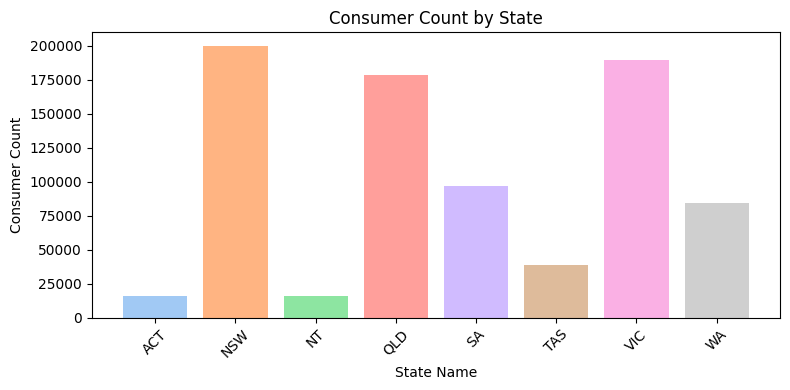

In [8]:
plot_consumer_count_by_state("Consumer Count by State", consumer_count_per_state, "State Name", "Consumer Count", '.'+CONSUMER_COUNT_BY_STATE_PLOT_PATH)

- Group by sa2 code and sa2 name, calculate the consumer count for each sa2 region

- We can see Mukinbudin (with sa2 code 509021242) has the most consumer count (2435.138793)

In [9]:
# group by the sa2 name and count the number of consumers
# we treat the ratio as the consumer count, because we only know the corresponding postcode of each consumer
# and each postcode may correspond to multiple sa2_code, so we can say the ratio is the contribution of the consumer for each sa2_code
consumer_count_in_sa2 = joined_consumer_with_sa2.groupby([SA2_CODE, SA2_NAME]).agg({RATIO: "sum"})
consumer_count_in_sa2 = consumer_count_in_sa2.reset_index()
consumer_count_in_sa2 = consumer_count_in_sa2.rename(columns={RATIO: "consumer_count"})
consumer_count_in_sa2 = consumer_count_in_sa2.merge(joined_consumer_with_sa2[[SA2_CODE, STE_NAME]], on=SA2_CODE, how=INNER_JOIN)
# drop the duplicate and sort by the consumer count in descending order, keep the top 100 sa2_code
top_100_consumer_count_in_sa2 = consumer_count_in_sa2.drop_duplicates(subset=[SA2_CODE]).sort_values(by="consumer_count", ascending=False).head(100)
top_100_consumer_count_in_sa2

,sa2_code,sa2_name,consumer_count,state_name
737049,509021242,Mukinbudin,2435.138793,WA
742560,509031247,Kulin,2402.961147,WA
734203,509021241,Moora,2374.852936,WA
370832,215031405,Swan Hill Surrounds,2243.391449,VIC
728462,509021238,Dowerin,2113.736537,WA
...,...,...,...,...
767950,602031058,Dilston - Lilydale,667.877223,TAS
508318,312021351,Pioneer Valley,667.725833,QLD
752076,601021012,South Arm,666.000000,TAS
672909,501031020,Pemberton,665.671464,WA


- Shows the number of sa2 codes from each state in the top 100 with the most consumers

In [10]:
# group by the sa2 name and count the number of consumers
sa2_count_per_state_in_top_100 = top_100_consumer_count_in_sa2.groupby(STE_NAME).agg({SA2_CODE: "count"})
sa2_count_per_state_in_top_100 = sa2_count_per_state_in_top_100.reset_index()
sa2_count_per_state_in_top_100 = sa2_count_per_state_in_top_100.rename(columns={SA2_CODE: "sa2_count"})
sa2_count_per_state_in_top_100

,state_name,sa2_count
0,NSW,13
1,QLD,13
2,SA,21
3,TAS,6
4,VIC,30
5,WA,17


- Here we see, in the top 100 sa2 code, most of them come from VIC(30), and SA(21), NT and ACT do not have any sa2 code in the top 100

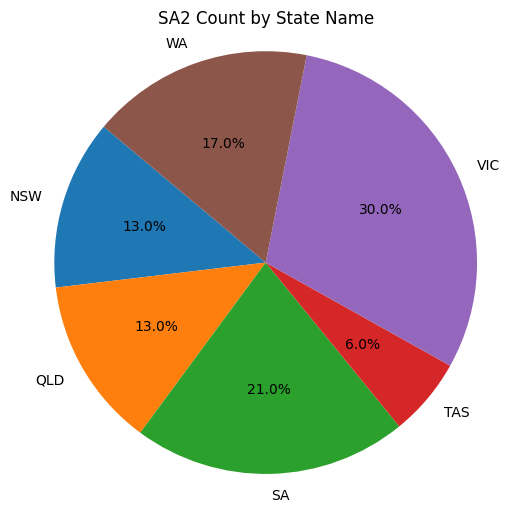

In [11]:
plot_pie_chart("SA2 Count by State Name", sa2_count_per_state_in_top_100["sa2_count"], sa2_count_per_state_in_top_100[STE_NAME], '.'+SA_COUNT_BY_STATE_PIE_PLOT_PATH)

- Secondly, visulize and compare the male and female ratio for each state for the official data and our consumer data

In [11]:
# for the externnal data group by state, calculate the total males and females for aeach state
official_male_and_female_count = external_data.groupby(STATE).agg({TOTAL_MALES: 'sum', TOTAL_FEMALES: 'sum'})

# calcualte the male and female ratio for each state
official_male_and_female_count['male_female_ratio'] = official_male_and_female_count[TOTAL_MALES] / official_male_and_female_count[TOTAL_FEMALES]

# only keep the male and female ratio column
official_male_and_female_ratio = official_male_and_female_count[['male_female_ratio']].rename(columns={'male_female_ratio': 'official_male_female_ratio'})

official_male_and_female_ratio = official_male_and_female_ratio.reset_index()

In [12]:
# Calculate the male and female count
consumer_male_and_female_count = consumer_data.groupby([STATE_NAME, GENDER]).size().unstack(fill_value=0)

# Calculate the male and female ratio
consumer_male_and_female_count['male_female_ratio'] = consumer_male_and_female_count['Male'] / consumer_male_and_female_count['Female']

# Calculate the undisclosed ratio
consumer_male_and_female_count['undisclosed_ratio'] = consumer_male_and_female_count['Undisclosed'] / (consumer_male_and_female_count['Male'] + consumer_male_and_female_count['Female'])

# Reset the index to make the state_name a regular column
consumer_male_and_female_ratio = consumer_male_and_female_count.reset_index()

# Keep only the desired columns
consumer_male_and_female_ratio = consumer_male_and_female_ratio[[STATE_NAME, 'male_female_ratio', 'undisclosed_ratio']]

# Rename the columns
consumer_male_and_female_ratio.rename(columns={'male_female_ratio': 'consumer_male_female_ratio', 'undisclosed_ratio': 'consumer_undisclosed_ratio'}, inplace=True)

consumer_male_and_female_ratio

gender,state_name,consumer_male_female_ratio,consumer_undisclosed_ratio
0,ACT,0.967213,0.110476
1,NSW,1.009277,0.109531
2,NT,0.971978,0.114396
3,QLD,0.979717,0.110821
4,SA,1.000810,0.112994
5,TAS,0.999291,0.116249
6,VIC,1.004854,0.111411
7,WA,1.000112,0.112163


In [13]:
# join the consumer male female ratio and official male and female ratio by state name
joined_male_and_female_ratio = join_consumer_and_external_male_and_female_ratio(consumer_male_and_female_ratio, official_male_and_female_ratio)
joined_male_and_female_ratio

,state_name,consumer_male_female_ratio,consumer_undisclosed_ratio,official_male_female_ratio
0,ACT,0.967213,0.110476,0.966092
1,NSW,1.009277,0.109531,0.996101
2,NT,0.971978,0.114396,1.064655
3,QLD,0.979717,0.110821,0.998547
4,SA,1.000810,0.112994,0.994205
5,TAS,0.999291,0.116249,1.004941
6,VIC,1.004854,0.111411,0.991669
7,WA,1.000112,0.112163,1.005498


From the plot we can see: 
- The consumer sex ratio is significantly lower than the official sex ratio in Northern Territory (NT)
- The consumer sex ratio is slightly higher than the official sex ratio in Australian Capital Territory (ACT), New South Wales (NSW), South Australia (SA) Victoria (VIC)
- The consumer sex ratio is slightly lower than the official sex ratio in Queensland (QLD), Tasmania (TAS), Western Australia (WA)
- The undisclosed ratio in each state is very low, and all of them are around 0.1

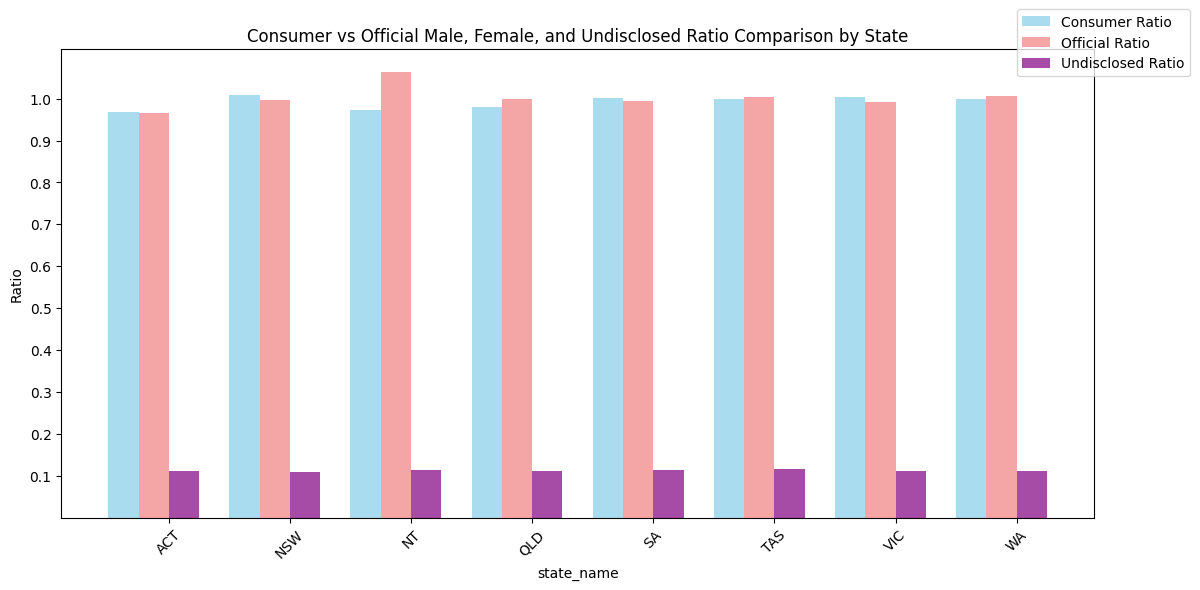

In [14]:
plot_ratio_comparison(joined_male_and_female_ratio, '.'+SEX_RATIO_COMPARISON_PLOT_PATH)

- Now we hope to see the camparison of sex ratio for sa2 region for the consumer data and the official data

In [15]:
joined_consumer_with_sa2

,name,address,state_name,postcode,gender,consumer_id,sa2_code,ratio,sa2_name
0,John Garza,90413 Wyatt Fort Apt. 516,SA,5301,Male,531402,407031169,0.575473,The Coorong
1,John Garza,90413 Wyatt Fort Apt. 516,SA,5301,Male,531402,407031161,0.424527,Karoonda - Lameroo
2,Latasha Rice,07972 Savannah Forest,SA,5301,Female,256822,407031169,0.575473,The Coorong
3,Latasha Rice,07972 Savannah Forest,SA,5301,Female,256822,407031161,0.424527,Karoonda - Lameroo
4,Andrew Steele,0149 Laura Bypass Apt. 350,SA,5301,Male,440042,407031169,0.575473,The Coorong
...,...,...,...,...,...,...,...,...,...
819590,Mr. Richard Wright,548 Meghan Island,NSW,2065,Male,468143,121041417,0.001327,North Sydney - Lavender Bay
819591,Mr. Richard Wright,548 Meghan Island,NSW,2065,Male,468143,121011401,0.343135,St Leonards - Naremburn
819592,Ronald Foster,940 Scott Mountain,NSW,2065,Male,1268261,121041414,0.438561,Crows Nest - Waverton
819593,Ronald Foster,940 Scott Mountain,NSW,2065,Male,1268261,121041417,0.001327,North Sydney - Lavender Bay


Use SQL in pandas to calculate the male and female ratio for each sa2 region

In [16]:
# create a database in memory
conn = sqlite3.connect(':memory:')

joined_consumer_with_sa2.to_sql('my_table', conn, index=False)

# execute the query and get the result
query = """
    SELECT
        SA2_CODE,
        SA2_NAME,
        SUM(CASE WHEN Gender = 'Male' THEN ratio ELSE 0 END) AS male_ratio,
        SUM(CASE WHEN Gender = 'Female' THEN ratio ELSE 0 END) AS female_ratio
    FROM
        my_table
    WHERE
        Gender != 'Undisclosed'
    GROUP BY
        SA2_CODE,
        SA2_NAME
"""

result = pd.read_sql_query(query, conn)
conn.close()

result['male_female_ratio'] = result['male_ratio'] / result['female_ratio']
result.drop(['male_ratio', 'female_ratio'], axis=1, inplace=True)
result

,sa2_code,sa2_name,male_female_ratio
0,101021007,Braidwood,0.853482
1,101021008,Karabar,1.263158
2,101021009,Queanbeyan,1.263158
3,101021010,Queanbeyan - East,1.263158
4,101021012,Queanbeyan West - Jerrabomberra,1.098608
...,...,...,...
1895,801091106,Mawson,1.101449
1896,801091107,O`Malley,0.721160
1897,801091108,Pearce,1.101449
1898,801091109,Phillip,0.719512


- We can see that in the top 100 sa2 region for the consumers, Johnstone (with sa2 code 306031160) has the higest male and female ratio with 1.156984, also Northern Midlands (with sa2 code 602031061) has the lowest male and female ratio (0.835141)

In [17]:
# append male and female ratio to the top 100 sa2_code
sex_ratio_and_customer_count_in_top_100_sa2 = top_100_consumer_count_in_sa2.merge(result[[SA2_CODE, 'male_female_ratio']], on=SA2_CODE, how=LEFT_JOIN)

sex_ratio_and_customer_count_in_top_100_sa2.rename(columns={'male_female_ratio': 'male_female_ratio'}, inplace=True)
sex_ratio_and_customer_count_in_top_100_sa2 = sex_ratio_and_customer_count_in_top_100_sa2.sort_values(by='male_female_ratio', ascending=False)
sex_ratio_and_customer_count_in_top_100_sa2

,sa2_code,sa2_name,consumer_count,state_name,male_female_ratio
59,306031160,Johnstone,879.983910,QLD,1.156984
63,401021004,Aldgate - Stirling,861.256686,SA,1.150400
89,405041128,Yorke Peninsula - South,684.167359,SA,1.149179
54,406011130,Eyre Peninsula,930.394620,SA,1.144440
60,105031099,Coonabarabran,877.870654,NSW,1.123612
...,...,...,...,...,...
51,501021014,Harvey,946.533531,WA,0.900894
83,604031097,West Coast (Tas.),715.784830,TAS,0.900840
25,307011174,Inglewood - Waggamba,1192.278806,QLD,0.895739
58,113031271,Wagga Wagga Surrounds,911.658357,NSW,0.893959


Plotting the bar chart for different sex ratio grouops for the top 100 sa2 region for the consumers
- Most of the sa2 region in top100 consumer sa2 regions have male and female sex ratio between 0.95 - 1.00
- Males are more than females for most of the sa2 region here

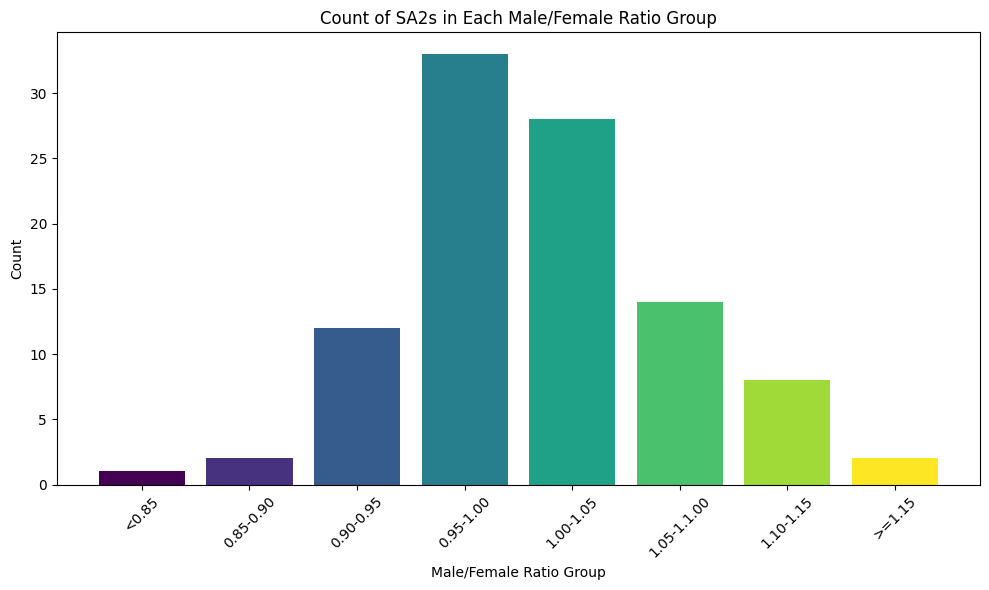

In [18]:
plot_bar_chart_of_sex_ratio_for_top_100_sa2(sex_ratio_and_customer_count_in_top_100_sa2, '.'+SEX_RATIO_AND_CUSTOMER_COUNT_IN_TOP100_SA2_PLOT_PATH)